# Init
We initialize google drive, import the libraries, and initialize whatever *global* variable we need.

## Google drive access

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/University/ANN/CHALLENGE1/

/gdrive/MyDrive/University/ANN/CHALLENGE1


## Importing libs

In [4]:
import os
import time
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers

In [5]:
!pip install visualkeras
import visualkeras

     |████████████████████████████████| 795 kB 5.3 MB/s 


## Setting seed

In [6]:
seed = 20

In [7]:
#@title init seed everywhere
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Some parameters init

In [28]:
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']
dataset_dir = 'training'
dataset_path = './training'

img_h, img_w = (256, 256)
input_shape = (img_h, img_w, 3)
epochs = 200
batch_size = 32

# check total number of files. It must be 17728 if no testset
def countInTraining():
  count = 0
  for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    for j in range(len(class_imgs)):
      count += 1
  print("In training: ", count)
  return count

## Unzip dataset

In [ ]:
#@title Run this cell to unzip data
!unzip dataset.zip

In [ ]:
#@title Plot example images from dataset
num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    print(class_imgs)
    # print(class_img)
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Only if evaluating the performance
If test folder is not present we create one. 

For each class type we generate a folder and we move 1/100 images of that type to that folder

In [36]:
isTest = True
test_path = "./test"
if not os.path.exists(test_path):
  import shutil
  os.mkdir(test_path)
  for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    # In this way we always get the same data. 
    # TODO: randomize using seed the data we take
    class_imgs.sort()
    # put in test 1/100 of the pictures of one folder
    for j in range(len(class_imgs) // 100):
      class_img = class_imgs[j]
      dest_dir = './test/' + labels[i] + '/'
      if not os.path.exists(dest_dir):
        os.mkdir(dest_dir)
      shutil.move('{}/{}/'.format(dataset_dir, labels[i]) + class_img, dest_dir)

countInTraining()

In training:  17559


17559

## If we want to submit the model
We do not generate test folder. 

If test folder is present we move the images back into the train folder and delete the test folder

In [35]:
isTest = False
test_path = "./test"
if os.path.exists(test_path):
  import shutil
  for i in range(len(labels)):
    class_imgs = next(os.walk('{}/{}/'.format(test_path, labels[i])))[2]
    # put back in training the picture in test
    for j in range(len(class_imgs)):
      class_img = class_imgs[j]
      dest_dir = './training/' + labels[i] + '/'
      shutil.move('{}/{}/'.format(test_path, labels[i]) + class_img, dest_dir)
  shutil.rmtree(test_path)

if countInTraining() != 17728:
  print("CAREFUL: some images could have been deleted")

In training:  17728


# Import data

In [1]:
#@title Another possible way to load the dataset
# # One possible way to load the dataset. I use another which was used also in class, using ImageDataGenerator
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   dataset_path,
#   validation_split=0.2,
#   subset="training",
#   seed=seed,
#   image_size=(img_h, img_w),
#   batch_size=batch_size)

# # Check sizes
# # train_ds is divided in batch of batch_size with images with shape (img_h, img_w, n_channels)
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

# val_ds = tf.keras.utils.image_dataset_from_directory(
#   dataset_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=seed,
#   image_size=(img_h, img_w),
#   batch_size=batch_size)

# # just trying to print some images in the train_ds
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(len(train_ds.class_names)):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(train_ds.class_names[labels[i]])
#     plt.axis("off")

In [37]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.

# Create an instance of ImageDataGenerator for training and validation
# We also apply data augmentation
image_generator = ImageDataGenerator(rotation_range=30,
                                      height_shift_range=50,
                                      width_shift_range=50,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True, 
                                      fill_mode='reflect',
                                      rescale=1./255, 
                                      validation_split=0.2)    


# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               classes=labels, # can be set to None
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               classes=labels, # can be set to None
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)
test_gen = None
if isTest:
  test_image_gen = ImageDataGenerator(rescale=1./255)
  test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                               target_size=(img_h, img_w),
                                               color_mode='rgb',
                                               classes=labels, # can be set to None
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed)

Found 14055 images belonging to 14 classes.
Found 3504 images belonging to 14 classes.
Found 169 images belonging to 14 classes.


(Input) image shape: (32, 256, 256, 3)
Target shape: (32, 14)

Categorical label: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 5
Class name: Orange


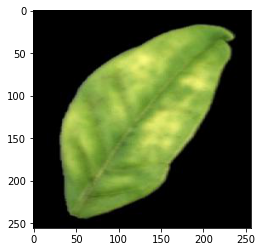

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

# Baseline model
I just use the model proposed in class

In [ ]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch. 
                                                                           # We use early stopping, thus, in this way we can save both the last and the best
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:
# Build model (for data augmentation training)
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        18496 

In [ ]:
tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs
# tf.get_logger().setLevel('ERROR') #  if you want to suppress both WARNINGs and INFOs

# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

In [ ]:
# Save best epoch model
model.save("experimets/baseline_best")